In [11]:
# Foundation imports
import softwarecorrelator.imaging as imaging

import numpy as np
import os
from urllib import request
import datetime
from astropy.time import Time, TimeDelta
import ast
from scipy.constants import c
from scipy.optimize import least_squares

import matplotlib.pyplot as plt
%matplotlib inline
# Useful defaults
nAntenna = 96
nPixels = 256
rcuMode = 3
activeElems = None
EU = 1
stationID = 'IE613'

# 16bit -> c128
# 8 bit -> c64
# 4bit -> c32

# Note for 4-bit data https://stackoverflow.com/questions/13863523/is-it-possible-to-create-a-numpy-ndarray-that-holds-complex-integers
# complex32 = np.dtype([('re', np.float16), ('im', np.float16)])
# myArr.view(np.float16).astype(np.float32).view(np.complex64)
sampleType = np.complex128


rcuMode2Str = [None, 							# 0
			'CalTable-{0}-LBA_OUTER-10_90.dat', # 1
			'CalTable-{0}-LBA_OUTER-30_90.dat', # 2
			'CalTable-{0}-LBA_INNER-10_90.dat', # 3
			'CalTable-{0}-LBA_INNER-30_90.dat', # 4
			'CalTable-{0}-HBA-110_190.dat', 	# 5
			'CalTable-{0}-HBA-170_230.dat',		# 6
			'CalTable-{0}-HBA-210_250.dat']		# 7

rcuMode2Str = [(val or '').format(stationID[2:]) for val in rcuMode2Str]


# StaticMetaData
# https://git.astron.nl/ro/lofar/-/tree/master/MAC/Deployment/data/StaticMetaData

# CalTables (Only place I can find them, not in the main git repo.)
# https://svn.astron.nl/Station/trunk/CalTables/

# Download configuration files and calibration tables to ./config/
if not os.path.exists("./config/"):
    os.mkdir("./config/")
fileLocations = {}
fileLocations['antennaField'] = f"./config/{stationID}-AntennaField.conf"
fileLocations['hbaDeltas'] = f"./config/{stationID}-iHBADeltas.conf"
fileLocations['calTable'] = f"./config/{rcuMode2Str[rcuMode]}"

print(fileLocations['calTable'])

request.urlretrieve(f"https://git.astron.nl/ro/lofar/-/raw/master/MAC/Deployment/data/StaticMetaData/AntennaFields/{fileLocations['antennaField'].split('/')[-1]}", fileLocations['antennaField'])
request.urlretrieve(f"https://git.astron.nl/ro/lofar/-/raw/master/MAC/Deployment/data/StaticMetaData/iHBADeltas/{fileLocations['hbaDeltas'].split('/')[-1]}", fileLocations['hbaDeltas'])
request.urlretrieve(f"https://svn.astron.nl/Station/trunk/CalTables/{stationID}/{fileLocations['calTable'].split('/')[-1]}", fileLocations['calTable'])

calTable = np.fromfile(fileLocations['calTable'], dtype = np.complex128)
# Drop the header
calTable = calTable[- (2 * nAntenna * 512):].reshape(2 * nAntenna, 512, order = 'F')
calX = calTable[::2]
calY = calTable[1::2]

./config/CalTable-613-LBA_INNER-10_90.dat


In [12]:
# Functions taken from allSkyImager
def calcFreq(rcuMode, subband):
	"""Find the frequency of a LOFAR observation given the rcuMode and subband
	
	Args:
	    rcuMode (int): RCU Mode during the observation
	    subband (int): Subband observed
	
	Returns:
	    float: Frequency of observation (in MHz)
	"""

	baseFreq = 100.0

	# Ensure we have cased to ints...
	rcuMode = int(rcuMode)
	subband = int(subband)
	if rcuMode == 5:
		freqOff = 100

	elif rcuMode == 6:
		freqOff = 160
		baseFreq = 80.0

	elif rcuMode == 7:
		freqOff = 200

	else:
		freqOff = 0

	frequency = ((baseFreq / 512 ) * (subband) + (freqOff))

	return frequency

def parseBlitzFile(linesArray, keyword, refLoc = False):
	"""Parse an element of a blitz config given the name of the array
	
	Args:
	    linesArray (list): List of lines in a given config file
	    keyword (string): Keyword to trigger extracting the next array
	    refLoc (bool, optional): if true, add an offset to account for an extra line prior to the array being read
	
	Returns:
	    np.ndarray: Blitz config array converted to numpy array
	"""

	# Strip all the newline characters
	linesArray = [line.strip('\n') for line in linesArray]

	# Find the provided trigger word
	triggerLine = [idx for idx, line in enumerate(linesArray) if line.startswith(keyword)][0]
	triggerLine += refLoc + 1 # refLoc = add a buffer line to account for a location refernece before processing.

	# If there is a ] on the trigger line, we are specifying a data shape. Parse it so we know the correct output shape.
	if ']' in linesArray[triggerLine]:
		line = linesArray[triggerLine]
		startIdx = line.find('[') + 1 # Don't include it as a character
		endIdx = line.find(']')

		dataElements = __processLine(line[startIdx:endIdx])
		return np.array(dataElements)

	# Find the close for the given data chunk
	endLine = [idx + triggerLine for idx, line in enumerate(linesArray[triggerLine:]) if ']' in line][0]
	iterateLines = range(triggerLine + 1, endLine)

	# Determine the number of dimensions in the output shape
	arrayShapeParts = linesArray[triggerLine].count('x') + 1

	# Get the line index of the start line
	startArrayLoc = linesArray[triggerLine].index('[') 

	# Get the elements defining the array shape
	splitTuples =  linesArray[triggerLine][:startArrayLoc].split('x')

	# Filter out spaces / null characters
	arrayShape = list(filter(None, splitTuples))[:arrayShapeParts]

	# Use ast to parse the values to their true type (int, tuple, string...), but it should always return an int for us here.
	arrayShape = [ast.literal_eval(strEle.strip(' ')) for strEle in arrayShape]
	arrayShape = [tuplePair[1] - tuplePair[0] + 1 for tuplePair in arrayShape]

	# Parse in the data, store in an array and then reshape it to the correct shape.
	# Process line splits up the elements and filters off empty strings, neede as there is an arbitrary number
	#	of spaces between data elements as tab characters are not used to separate them.
	arrayData = []
	for lineIdx in iterateLines:
		procLine = __processLine(linesArray[lineIdx])
		arrayData.append(procLine)

	arrayData = np.vstack(arrayData).reshape(arrayShape)

	return arrayData

def __processLine(line):
	"""Convert a blitz line to be purely float elements
	
	Args:
	    line (string): Blitz config sub-array line
	
	Returns:
	    list(float): Processed line
	"""
	line = filter(None, line.split(' '))
	return [float(element) for element in line] 



elemsDict={'Effelsberg_elements_20091110' : [1,4,13,15,11,9,14,1,15,0,8,2,11,3,14,0,2,4,3,0,0,2,12,12,12,12,15,11,14,15,7,5,1,0,3,10,1,11,0,12,12,1,6,7,0,10,9,6,15,14,11,7,2,0,7,12,15,8,13,3,7,6,3,15,11,1,4,11,8,1,8,15,4,0,5,6,12,0,12,15,3,7,14,8,3,12,12,2,9,8,14,2,5,6,12,0], 
	'Generic_International_Station_20091110' : [15,0,15,3,9,15,14,2,0,3,4,14,10,8,5,15,12,0,2,11,3,12,12,1,5,4,4,8,6,3,0,5,3,11,3,2,8,15,13,8,3,2,9,1,14,8,8,0,12,13,0,11,15,3,12,3,13,3,10,5,0,10,1,6,4,10,3,15,3,14,0,12,0,7,0,12,7,3,13,0,7,3,15,4,14,4,3,8,4,9,12,0,14,9,3,11],
	'Generic_Int_201512' : [0,5,3,1,8,3,12,15,10,13,11,5,12,12,5,2,10,8,0,3,5,1,4,0,11,6,2,4,9,14,15,3,7,5,13,15,5,6,5,12,15,7,1,1,14,9,4,9,3,9,3,13,7,14,7,14,2,8,8,0,1,4,2,2,12,15,5,7,6,10,12,3,3,12,7,4,6,0,5,9,1,10,10,11,5,11,7,9,7,6,4,4,15,4,1,15],
	'Generic_Core_201512' : [0,10,4,3,14,0,5,5,3,13,10,3,12,2,7,15,6,14,7,5,7,9,0,15,0,10,4,3,14,0,5,5,3,13,10,3,12,2,7,15,6,14,7,5,7,9,0,15],
	'Generic_Remote_201512' : [0,13,12,4,11,11,7,8,2,7,11,2,10,2,6,3,8,3,1,7,1,15,13,1,11,1,12,7,10,15,8,2,12,13,9,13,4,5,5,12,5,5,9,11,15,12,2,15]}

def configureStation(fileLocations, activeElems, rcuMode, EU):
	"""Previously known as parseiHBAField, rewritten to be a lot cleaner and easier to maintain. Renamed to more clearly describe it's purpose.

	Initially ported from ASTRON's MATLab code to Python by Joe McCauley.
	
	Args:
	    fileLocations (list): Location of the *-AntennaField.conf and *-iHBADeltas.conf files
	    activeElems (string): Name of the activation pattern ()
	    rcuMode (int): RCU Mode during observation
	    EU (bool): Are we using an international station? Set this to True.
	
	
	Returns:
	    posXPol, [lon, lat, height], arrayLoc, antLocs: X-Polarisation antenna locations (matches Y), station Location (lon, lat, alt (m)), array location in GCRS, Raw GCRC and Station-Coordinate antenna locations
	"""
	afilename, hbaDeltasFile = fileLocations['antennaField'], fileLocations['hbaDeltas']

	# If we specify an activation pattern, grab it and cache the offsets from tile centers.
	if activeElems:
		activeElements = elemsDict[activeElems]

		with open(hbaDeltasFile, 'r') as hbaDeltasRef:
			deltaLines = [line for line in hbaDeltasRef]

		arrayDeltas = parseBlitzFile(deltaLines, 'HBADeltas', False)

	
	# Classify antenna type by rcuMode
	if rcuMode in [1, 2, 3, 4]:
		arrayName = 'LBA'
	else:
		arrayName = 'HBA'

	# Load in a copy of the array config and parse
	with open(afilename, 'r') as arrayRef:
		arrayLines = [line for line in arrayRef]
	
	pqr_to_itrs_matrix = parseBlitzFile(arrayLines, f"ROTATION_MATRIX {arrayName}", False)
	arrayLoc = parseBlitzFile(arrayLines, arrayName, False)
	antLocs = parseBlitzFile(arrayLines, arrayName, True)
    

	# Select the X/Y antenna locations (should be the same) then apply an activation pattern if we defined one
	posX = antLocs[:, 0, :]

	if activeElems:
		posX += arrayDeltas[activeElements]

	# For incomplete antenna sets (Core / remote?) only include the relevant antenna due to their reduced RSP count.
	if not EU:
		nElem = posX.shape[0]
		if rcuMode in [1, 2]:
			sel = range(nElem/2,nElem) #sel=25:48
		elif rcuMode in [3, 4]:
			sel = range(0,nElem/2)         #sel=1:24
		else:
			sel = range(0,nElem)
		
		posX = posX[sel, :]
	
    # Parse and apply the rotation matrix from the blitz file to convert to station coordinates from real coordinates.
    # If 'HBA0' is in the array config, we have a split array defined and thus need to rotate the elements individually.
    # This should only be triggered when EU is false.

    # Use matrices for easier linear algebra operations
	posX = np.matrix(posX)
	if 'HBA0\n' in arrayLines:
		####Matlab code. Needs porting for completeness
		#        while ~((strcmp(token, 'HBA1') && strcmp(prevtoken, 'ROTATION_MATRIX')) || isempty(token))
		#            prevtoken = token;
		#            token = fscanf(fid, '#s', 1);
		#        end
		#        fscanf(fid, '#s', 4);
		#        rotmat2 = zeros(3, 3);
		#        rotmat2(:) = fscanf(fid, '#f', 9);
		#        posxpol(1:nElem/2, :) = posxpol(1:nElem/2, :) / rotmat;
		#        posxpol(nElem/2+1:nElem, :) = posxpol(nElem/2+1:nElem, :) / rotmat2;
		#        posypol(1:nElem/2, :) = posypol(1:nElem/2, :) / rotmat;
		#        posypol(nElem/2+1:nElem, :) = posypol(nElem/2+1:nElem, :) / rotmat2;
		####Matlab code end

		# David McKenna: Port attempted based on python implementation of else statement by Joe McCauley (don't have access to orignal source outside of the block left above). 
		# Untested as I don't have matlab to test the actual intended output and haven't pointed from a core/remote station yet.
		rotationMatrixOne = parseBlitzFile(arrayLines, 'ROTATION_MATRIX ' + arrayName + '0', False).T

		posX[:, :nElem/2+1] = posX[:, :nElem/2+1] * np.linalg.pinv(rotationMatrixOne)

		posX[:, nElem/2+1:] = posX[:, nElem/2+1:] * np.linalg.pinv(rotationMatrixTwo)

		rotationMatrix = np.dstack([rotationMatrixOne, rotationMatrixTwo])

	else:
		rotationMatrix = parseBlitzFile(arrayLines, 'ROTATION_MATRIX ' + arrayName, False).T #has to be transposed to get into correct format for further operations below
		rotationMatrix = np.matrix(rotationMatrix)

		posX = posX * np.linalg.pinv(rotationMatrix)

	posX = np.array(posX)

	return posX, arrayLoc, pqr_to_itrs_matrix

In [13]:
# StaticMetaData
# https://git.astron.nl/ro/lofar/-/tree/master/MAC/Deployment/data/StaticMetaData

# CalTables (Only place I can find them, not in the main git repo.)
# https://svn.astron.nl/viewvc/Station/trunk/StationTables/


# What we want to call:
#     MatrixImager(uvw_m, num_pixels, freq_hz, [limits]).[compute_predict_matrix(source_lmn_rad), dft_image(acm_vector, [weights?])]
# Requires results from: 
#     positions_m = configureStation(fileLocations, activeElems, rcuMode, EU)
#     acm = np.loaddata(datFile, shape = (nAntenna, nAntenna, -1), dtype = sampleType)
#     [u, v, w] = baseline_matrix_m(positions_m) # I though this would be x, y ,z, not u, v, w, but that's how Michiel's doing it...
#     acm_vector = acm_as_vector(acm)
#     freq_hz = calcFreq(rcuMode, subband) * 1e6
#     source_lmn_rad = SkyModel(pqr_to_itrs_matrix, observing_location_itrs).above_horizon(obsTime)
#     

394 76953125.0 2020-10-29 05:10:08
Predicting sources: ['Cas A', 'Cyg A', 'Vir A', 'Tau A', 'Per A', '3C 123', '3C 295', '3C 196', 'DR 4', 'DR 23', 'DR 21']
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.3856e+11                                    3.54e+07    
       1              2         7.3467e+11      3.89e+09       2.08e+02       1.91e+07    
       2              3         7.2736e+11      7.31e+09       3.80e+02       1.78e+07    
       3              4         7.1434e+11      1.30e+10       7.60e+02       1.52e+07    
       4              5         6.9462e+11      1.97e+10       1.52e+03       9.88e+06    
       5              6         6.8024e+11      1.44e+10       3.04e+03       4.08e+09    
       6             12         6.8016e+11      7.86e+07       1.82e+02       3.04e+08    
       7             13         6.8014e+11      1.95e+07       7.81e+01       7.62e+07    
       8             14 

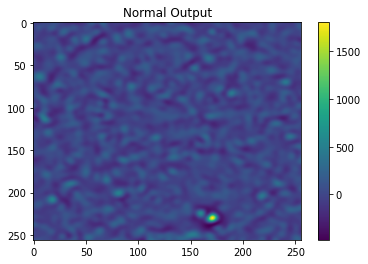

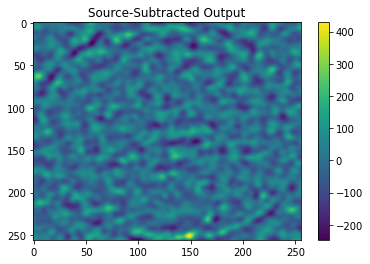

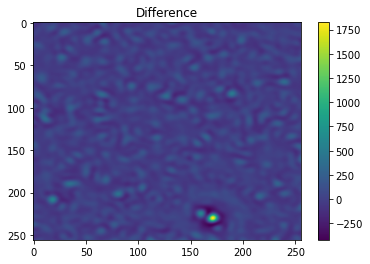

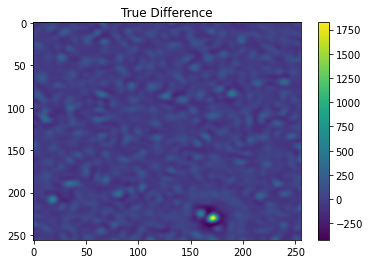

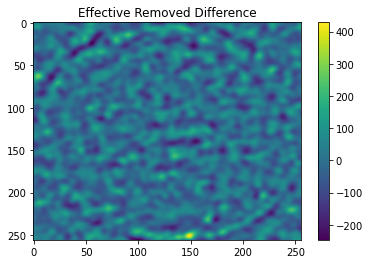

Cas A: 5538.738999132956
Cyg A: 446.7115587179908
Vir A: 512.2537984951964
Tau A: 1299.833673039121
Per A: 4.593627672548375e-24
3C 123: 178.10535940906976
3C 295: 8.060238335666427e-23
3C 196: 8.601164649860539e-26
DR 4: 426.24091294274126
DR 23: 342.14506931518787
DR 21: 355.9852775611825


In [17]:
# Get the first file in the folder
fileName = [filename for filename in os.listdir("./") if filename.endswith(".dat")][0]

# Determne the frequency, time information
subband = int([chunk.replace("sb", "") for chunk in fileName.split('_') if 'sb' in chunk][0])
freq_hz = calcFreq(rcuMode, subband) * 1e6
obsTime = Time(datetime.datetime.strptime(fileName[:15], "%Y%m%d_%H%M%S"))

print(subband, freq_hz, obsTime)
# Determine the antenna locations, baselines, pqr matrix
positions_m, arrayLoc, pqr_to_itrs_matrix = configureStation(fileLocations, activeElems, rcuMode, EU)
posData = np.load("./bl.npy")
uvw_m = imaging.baseline_matrix_m(posData[:, 0, :])
x, y = np.triu_indices(nAntenna, 1)
uvw_v = uvw_m[x, y, :]



"""
plt.hist(np.sum(np.square(uvw_v), axis = 1))
plt.show()
plt.figure()
plt.scatter(uvw_v[:, 0], uvw_v[:, 1])
plt.show()
plt.figure()
"""


# Load the first correlation from the xst file.
# XSTs have both the X correlation and Y correlation... there goes 2 hours.
acm = np.fromfile(fileName, count = 4 * nAntenna * nAntenna, dtype = sampleType).reshape(2 * nAntenna, 2 * nAntenna)[1::2, 1::2]
acm_vector = imaging.acm_as_vector(acm)

calSubbandX = calY[:, subband]
calSubbandX = np.outer(calSubbandX, np.conj(calSubbandX).T)[x, y]
#acm_vector = np.multiply(np.conj(calSubbandX), acm_vector)
# Get the source information
skyModel = imaging.SkyModel(pqr_to_itrs_matrix, arrayLoc)
names, source_lmn_rad = skyModel.above_horizon(obsTime)
print("Predicting sources:", names)

# Generte an imager
#imager = imaging.MatrixImager(uvw_v, nPixels, freq_hz)
imager = imaging.MatrixImager(uvw_v, nPixels, freq_hz, min_baseline_lambda = 4)
predictionMatrix = imager.compute_predict_matrix(source_lmn_rad)

# Generate an image
image1 = imager.dft_image(acm_vector)


# Attempt to find a solution for x, in Ax = b
def lsqCost(x, A, b, calMatrix):
    return np.square((b - np.multiply(np.conj(calSubbandX), np.dot(A, x))).real)

np.random.seed(0)
modelGuess = np.abs(np.random.rand(predictionMatrix.shape[1]).astype(np.float64)) * 100
modelBrightnessResult = least_squares(lsqCost, modelGuess, args = (predictionMatrix, acm_vector, calSubbandX), loss = 'huber', bounds = (0., np.inf), verbose = 2)


plt.imshow(image1, aspect = 'auto')
plt.title("Normal Output")
plt.colorbar()
plt.show()


plt.figure()
image2 = imager.dft_image(acm_vector - np.multiply(np.conj(calSubbandX), np.dot(predictionMatrix, modelBrightnessResult.x)))
image3 = imager.dft_image(np.multiply(np.conj(calSubbandX), np.dot(predictionMatrix, modelBrightnessResult.x)))
plt.imshow(image2, aspect = 'auto')
plt.title("Source-Subtracted Output")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(image1 - image2, aspect = 'auto')
plt.title("Difference")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(image3, aspect = 'auto')
plt.title("True Difference")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(image1 - image3, aspect = 'auto')
plt.title("Effective Removed Difference")
plt.colorbar()
plt.show()

for name, brightness in zip(names, modelBrightnessResult.x):
    print(f"{name}: {brightness}")

In [7]:
posData = np.load("./bl.npy")
print(posData.shape)
print(predictionMatrix.shape)

(96, 1, 3)
(4560, 10)


(96, 1, 3)


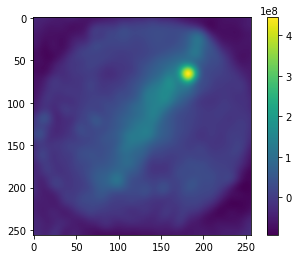

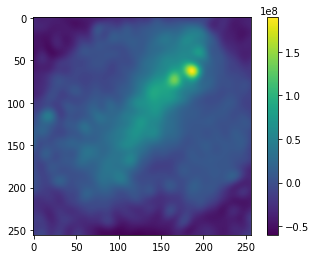

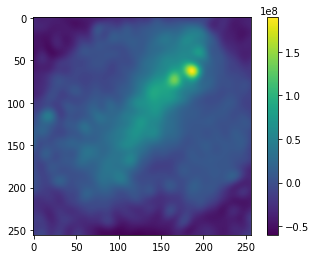

In [8]:
posData = np.load("./bl.npy")
print(posData.shape)

acm = np.fromfile(fileName, count = 4 * nAntenna * nAntenna, dtype = sampleType).reshape(2 * nAntenna, 2 * nAntenna)[1::2, 1::2]
acm_new = np.zeros_like(acm)
acm_new[x, y] = acm[x, y]

lVec = np.linspace(-1, 1, 256)[:, np.newaxis]
mVec = np.linspace(-1, 1, 256)[:, np.newaxis]
wavelength = c / freq_hz
k = (2 * np.pi) / wavelength
wX = np.exp(-1j * k * posData[:, :, 0].T * lVec).T
wY = np.exp(-1j * k * posData[:, :, 1].T * lVec).T


weight = np.multiply(wX[:, np.newaxis, :], wY[:, :, np.newaxis]).transpose((1,2,0))[..., np.newaxis]
conjWeight = np.conj(weight).transpose((0,1,3,2))
result = np.sum(np.multiply(np.dot(conjWeight, acm_new).transpose((0,1,3,2)), weight),  axis = (2,3))

plt.imshow(result.real)
plt.colorbar()
plt.show()
plt.figure()


acm_newc = np.zeros_like(acm_new)
acm_newc[x, y] = np.multiply(np.conj(calSubbandX), acm_new[x, y])
result2 = np.sum(np.multiply(np.dot(conjWeight, acm_newc).transpose((0,1,3,2)), weight),  axis = (2,3))

plt.imshow(result2.real)
plt.colorbar()
plt.show()
plt.figure()


acm_new2 = np.zeros_like(acm)
acm_new2[x, y] = acm_newc[x, y] -  np.multiply(np.conj(calSubbandX), np.dot(predictionMatrix, modelBrightnessResult.x))
result3 = np.sum(np.multiply(np.dot(conjWeight, acm_new2).transpose((0,1,3,2)), weight),  axis = (2,3))

plt.imshow(result2.real)
plt.colorbar()
plt.show()

(96, 96) [[ 0.          8.20666279  3.86870608 ... 11.07907495 14.59699283
  24.97337836]
 [ 8.20666279  0.          6.5047985  ... 15.16793768 20.30765492
  19.91408013]
 [ 3.86870608  6.5047985   0.         ... 14.64677612 18.45097489
  25.60437893]
 ...
 [11.07907495 15.16793768 14.64677612 ...  0.          5.77174156
  21.40655761]
 [14.59699283 20.30765492 18.45097489 ...  5.77174156  0.
  26.49409309]
 [24.97337836 19.91408013 25.60437893 ... 21.40655761 26.49409309
   0.        ]]


In [ ]:
# Get the first file in the folder
fileName = [filename for filename in os.listdir("./") if filename.endswith(".dat")][0]

# Determne the frequency, time information
subband = int([chunk.replace("sb", "") for chunk in fileName.split('_') if 'sb' in chunk][0])
freq_hz = calcFreq(rcuMode, subband) * 1e6
obsTime = Time(datetime.datetime.strptime(fileName[:15], "%Y%m%d_%H%M%S"))

print(subband, freq_hz, obsTime)
# Determine the antenna locations, baselines, pqr matrix
positions_m, arrayLoc, pqr_to_itrs_matrix = configureStation(fileLocations, activeElems, rcuMode, EU)
uvw_m = imaging.baseline_matrix_m(positions_m)
x, y = np.triu_indices(nAntenna, 1)
uvw_v = uvw_m[x, y, :]



"""
plt.hist(np.sum(np.square(uvw_v), axis = 1))
plt.show()
plt.figure()
plt.scatter(uvw_v[:, 0], uvw_v[:, 1])
plt.show()
plt.figure()
"""


# Load the first correlation from the xst file.
# XSTs have both the X correlation and Y correlation... there goes 2 hours.
acm = np.fromfile(fileName, count = 4 * nAntenna * nAntenna, dtype = sampleType).reshape(2 * nAntenna, 2 * nAntenna)[::2, ::2]
acm_vector = imaging.acm_as_vector(acm)



# Get the source information
skyModel = imaging.SkyModel(pqr_to_itrs_matrix, arrayLoc)
__, source_lmn_rad = skyModel.above_horizon(obsTime)


# Generte an imager
imager = imaging.MatrixImager(uvw_v, nPixels, freq_hz)
#imager = imaging.MatrixImager(uvw_v, nPixels, freq_hz, min_baseline_lambda = 4)
#predictionMatrix = imager.compute_predict_matrix(source_lmn_rad)

# Generate an image
image = imager.dft_image(acm_vector)
plt.imshow(image, aspect = 'auto')